In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

# Load datasets (adjust paths as needed)
truth_df = pd.read_csv('../processed_data/weekly_with_covariates.csv')
preds_df = pd.read_csv('../processed_data/weekly_predictions_with_covariates.csv')

# Clean column names
truth_df.columns = truth_df.columns.str.strip()
preds_df.columns = preds_df.columns.str.strip()

# Convert dates and filter 2019-2023
truth_df['week_start'] = pd.to_datetime(truth_df['week_start'])
preds_df['week_start'] = pd.to_datetime(preds_df['week_start'])

truth_df = truth_df[(truth_df['week_start'].dt.year >= 2019) & (truth_df['week_start'].dt.year <= 2023)]
preds_df = preds_df[(preds_df['week_start'].dt.year >= 2019) & (preds_df['week_start'].dt.year <= 2023)]

# Add 'year' column for merging
truth_df['year'] = truth_df['week_start'].dt.year
preds_df['year'] = preds_df['week_start'].dt.year

In [4]:
# Merge on spatial-temporal keys
df = pd.merge(
    truth_df,
    preds_df,
    on=['HEXid_weekID', 'week_id', 'year'],
    how='inner',
    suffixes=('_truth', '_preds')
)

# Rename key variables for clarity
df = df.rename(columns={
    'EcoCntr_weekly_SUM_truth': 'actual',
    'SUM_total_trip_count_truth': 'strava_raw',
    'predicted_eco_from_model': 'predicted'
})

print(f"Merged data shape: {df.shape}")

Merged data shape: (3364, 286)


Summary Statistics:
             actual    strava_raw
count   3364.000000   3364.000000
mean    2315.852556   4484.667063
std     2292.407092   7231.196025
min        0.000000      5.000000
25%      698.000000    720.000000
50%     1490.500000   1912.500000
75%     3489.250000   4416.250000
max    25277.000000  56525.000000


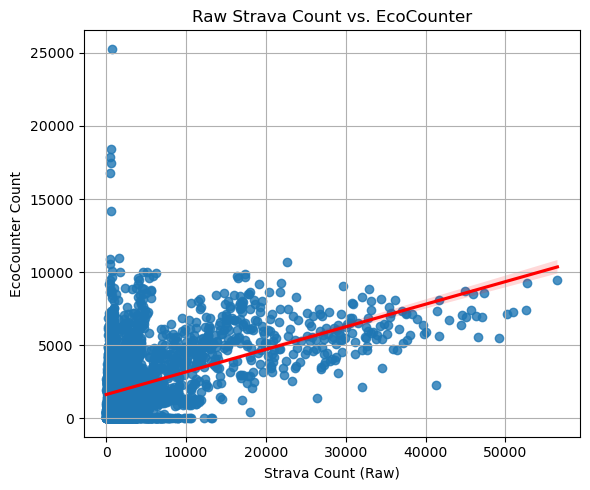

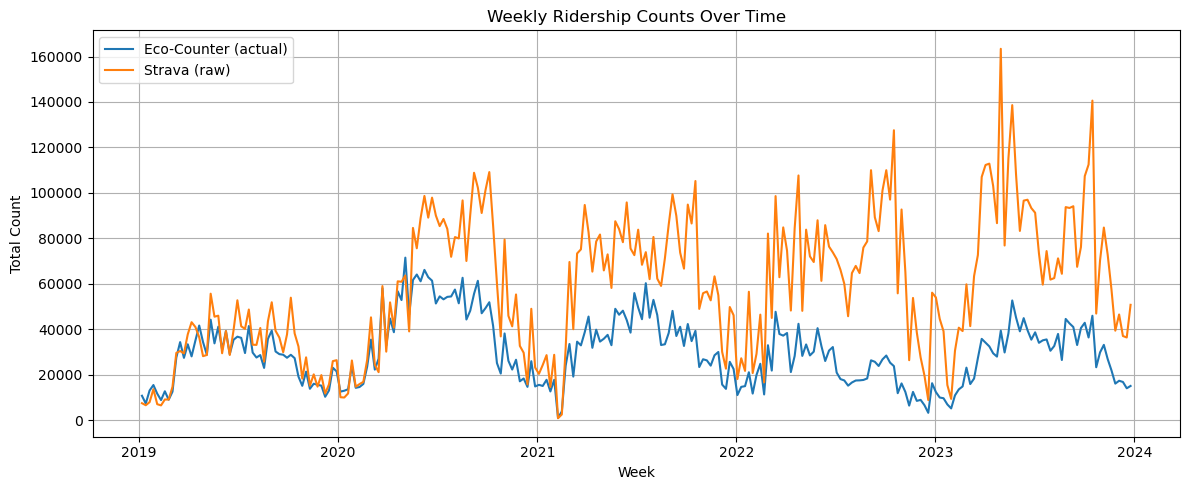

In [5]:
# Summary stats
print("Summary Statistics:")
print(df[['actual', 'strava_raw']].describe())

# Scatter plot: Raw Strava vs EcoCounter
plt.figure(figsize=(6, 5))
sns.regplot(x='strava_raw', y='actual', data=df, line_kws={'color': 'red'})
plt.title("Raw Strava Count vs. EcoCounter")
plt.xlabel("Strava Count (Raw)")
plt.ylabel("EcoCounter Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Time series example (aggregated)
ts_df = df.groupby('week_start_truth')[['actual', 'strava_raw']].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(ts_df['week_start_truth'], ts_df['actual'], label='Eco-Counter (actual)')
plt.plot(ts_df['week_start_truth'], ts_df['strava_raw'], label='Strava (raw)')
plt.title("Weekly Ridership Counts Over Time")
plt.xlabel("Week")
plt.ylabel("Total Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Summary Statistics (Bias-Corrected Predictions):
             actual     predicted
count   3364.000000   3364.000000
mean    2315.852556   2335.244588
std     2292.407092   1623.350712
min        0.000000    -73.315814
25%      698.000000    990.025561
50%     1490.500000   2100.638012
75%     3489.250000   3487.446145
max    25277.000000  10836.091557


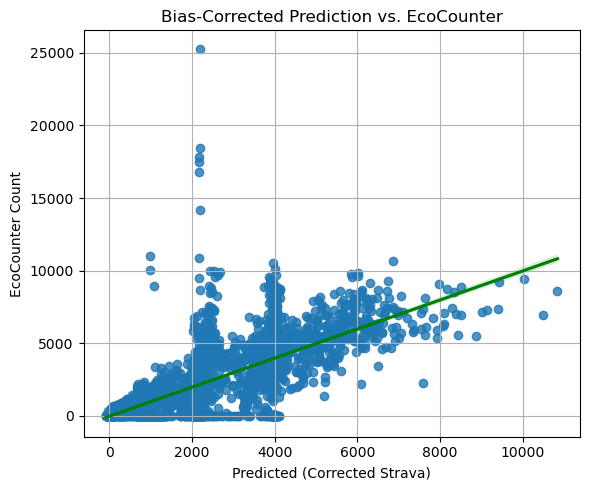

Model Performance Metrics:
MAE  = 1023.21
RMSE = 1617.66
R²   = 0.502


In [6]:
# Summary stats for bias-corrected predictions
print("Summary Statistics (Bias-Corrected Predictions):")
print(df[['actual', 'predicted']].describe())

# Scatter plot: Bias-Corrected Prediction vs EcoCounter
plt.figure(figsize=(6, 5))
sns.regplot(x='predicted', y='actual', data=df, line_kws={'color': 'green'})
plt.title("Bias-Corrected Prediction vs. EcoCounter")
plt.xlabel("Predicted (Corrected Strava)")
plt.ylabel("EcoCounter Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute model performance metrics
mae = mean_absolute_error(df['actual'], df['predicted'])
rmse = np.sqrt(mean_squared_error(df['actual'], df['predicted']))
r2 = r2_score(df['actual'], df['predicted'])

print(f"Model Performance Metrics:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# Optional: Save metrics
os.makedirs("processed_data", exist_ok=True)
with open("processed_data/model_metrics.txt", "w") as f:
    f.write(f"MAE:  {mae:.2f}\n")
    f.write(f"RMSE: {rmse:.2f}\n")
    f.write(f"R2:   {r2:.3f}\n")

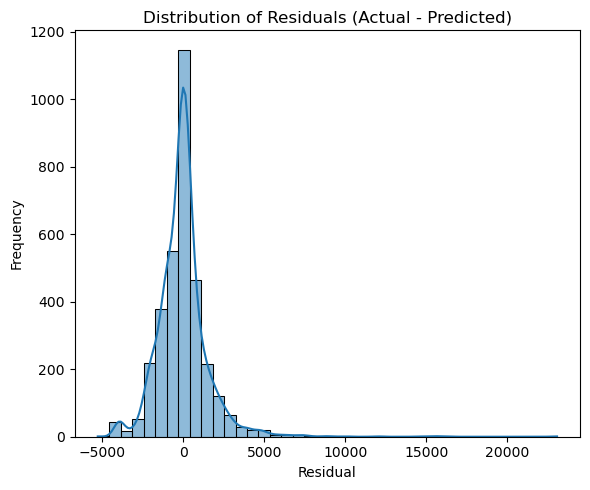

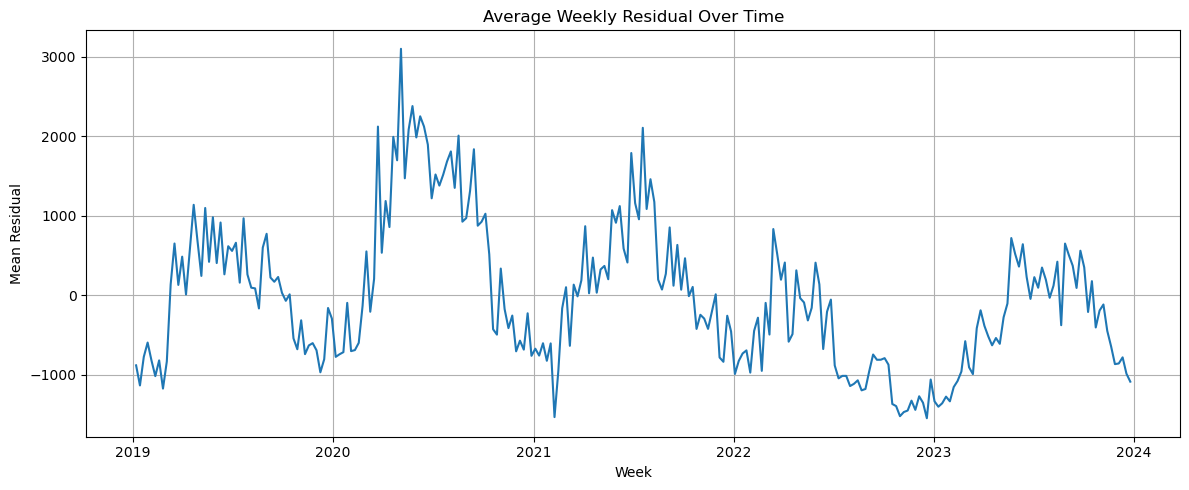

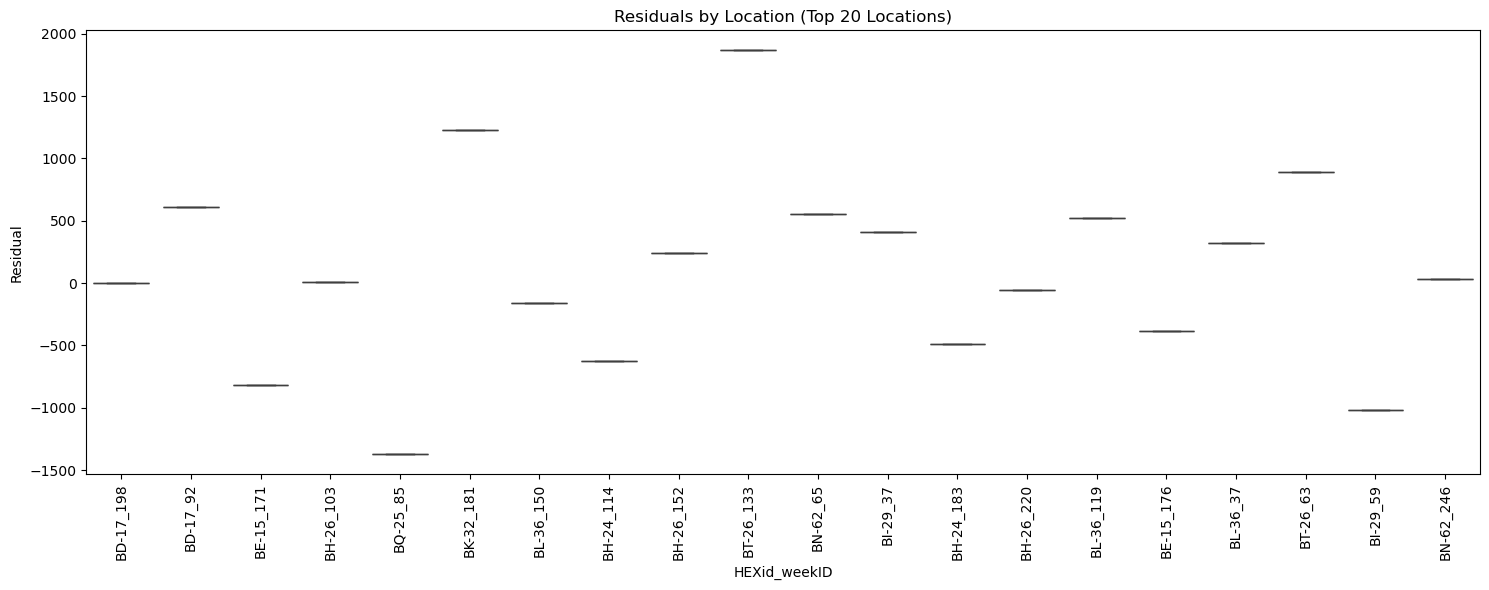

In [7]:
# Calculate residuals
df['residual'] = df['actual'] - df['predicted']

# Residual distribution
plt.figure(figsize=(6, 5))
sns.histplot(df['residual'], bins=40, kde=True)
plt.title("Distribution of Residuals (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Residuals over time example (aggregated weekly mean residual)
weekly_resid = df.groupby('week_start_truth')['residual'].mean().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(weekly_resid['week_start_truth'], weekly_resid['residual'])
plt.title("Average Weekly Residual Over Time")
plt.xlabel("Week")
plt.ylabel("Mean Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Spatial residuals - boxplot by location (if too many, sample top 20 locations)
top_locations = df['HEXid_weekID'].value_counts().index[:20]
df_top_loc = df[df['HEXid_weekID'].isin(top_locations)]

plt.figure(figsize=(15, 6))
sns.boxplot(x='HEXid_weekID', y='residual', data=df_top_loc)
plt.xticks(rotation=90)
plt.title("Residuals by Location (Top 20 Locations)")
plt.ylabel("Residual")
plt.xlabel("HEXid_weekID")
plt.tight_layout()
plt.show()
